
$\newcommand{\ensuremath}[1]{#1}
%% MATH STYLES
\newcommand{\mat}[1]{\ensuremath{\boldsymbol{\mathrm{#1}}}}
\newcommand{\mel}[1]{\ensuremath{{\mathrm{#1}}}}
\newcommand{\phym}[1]{\ensuremath{\mathsf{#1}}}
\newcommand{\range}[1]{\ensuremath{[#1]}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\abs}[1]{\left\lvert#1\right\rvert}
\newcommand{\defeq}[0]{:=}$

In [1]:
import sys

pypsapath = "C:/dev/py/PyPSApretty"

if sys.path[0] != pypsapath:
    sys.path.insert(0,pypsapath)

%load_ext autoreload
%autoreload 2

In [2]:
import pypsa
import numpy as np
import pandas as pd
import scipy as sp
import os

import matplotlib.pyplot as plt
import matplotlib.cm
import matplotlib.ticker

from IPython.display import Markdown, display
printm = lambda s: display(Markdown(s))

In [3]:
pretty = True
highres = True

%matplotlib inline
if highres:
    %config InlineBackend.figure_format = 'retina'
else:
    %config InlineBackend.figure_format = 'png'

#rcParams["figure.dpi"]=300
plt.rcParams['figure.figsize'] = [12, 6]
matplotlib.rcParams.update({'font.size': 12})

In [4]:
csv_folder_name = pypsapath + "/examples/scigrid-de/scigrid-with-load-gen-trafos/"

network = pypsa.Network(import_name=csv_folder_name)
contingency_factor_scaled = False

Importing PyPSA from older version of PyPSA than current version 0.13.2.
Please read the release notes at https://pypsa.org/doc/release_notes.html
carefully to prepare your network for import.

INFO:pypsa.io:Imported network  has buses, generators, lines, loads, storage_units, transformers


In [5]:
bus_names = list(network.buses.index)
bus_names_220_suffix = [n for n in bus_names if n[-6:]=="_220kV"]
suffix_removed = [n[:-6] for n in bus_names_220_suffix]
pairs = list(zip(suffix_removed, bus_names_220_suffix))

pd.set_option('display.max_columns', None)
pd.reset_option('display.max_rows')


generator_buses = network.generators.bus.unique()

As disucussed in the SciGRID dataset analysis, the set of nodes contains transformer pairs (to allow for two different operating voltages in the model). We will normalise the voltage at each line, and we will consider these transformer pairs as a single node. 

Let's construct the sets $\mathcal{N}$ and $\mathcal{L}$.

In [6]:
n = len(generator_buses)
m = len(network.lines)

# N:
new_nodes = sorted(list(generator_buses))


def node_index(bus_name):
    if bus_name in suffix_removed:
        return node_index(bus_name + "_220kV")
    return new_nodes.index(bus_name)

# L:
new_lines = [(node_index(a),node_index(b)) for i,a,b in network.lines[['bus0','bus1']].itertuples()]

operating_voltage_lines = network.lines.voltage.values

"""
operating_voltage_nodes = np.zeros(n)

for (a, b), vop in zip(new_lines, operating_voltage_lines):
    operating_voltage_nodes[a] = vop
    operating_voltage_nodes[b] = vop
"""

'\noperating_voltage_nodes = np.zeros(n)\n\nfor (a, b), vop in zip(new_lines, operating_voltage_lines):\n    operating_voltage_nodes[a] = vop\n    operating_voltage_nodes[b] = vop\n'

Let's construct $\mat{C}$ from the definition:

In [7]:
def edge_vertex_incidence_matrix(vertices, edges):
    row_indices = np.arange(len(edges)).repeat(2)
    column_indices = np.concatenate(edges)
    data = np.repeat([[1,-1]], repeats=len(edges), axis=0).flatten()
    return sp.sparse.csr_matrix((data, (row_indices, column_indices)), shape=(len(edges),len(vertices)))

C = edge_vertex_incidence_matrix(new_nodes, new_lines)

CV = sp.sparse.diags(operating_voltage_lines)*C

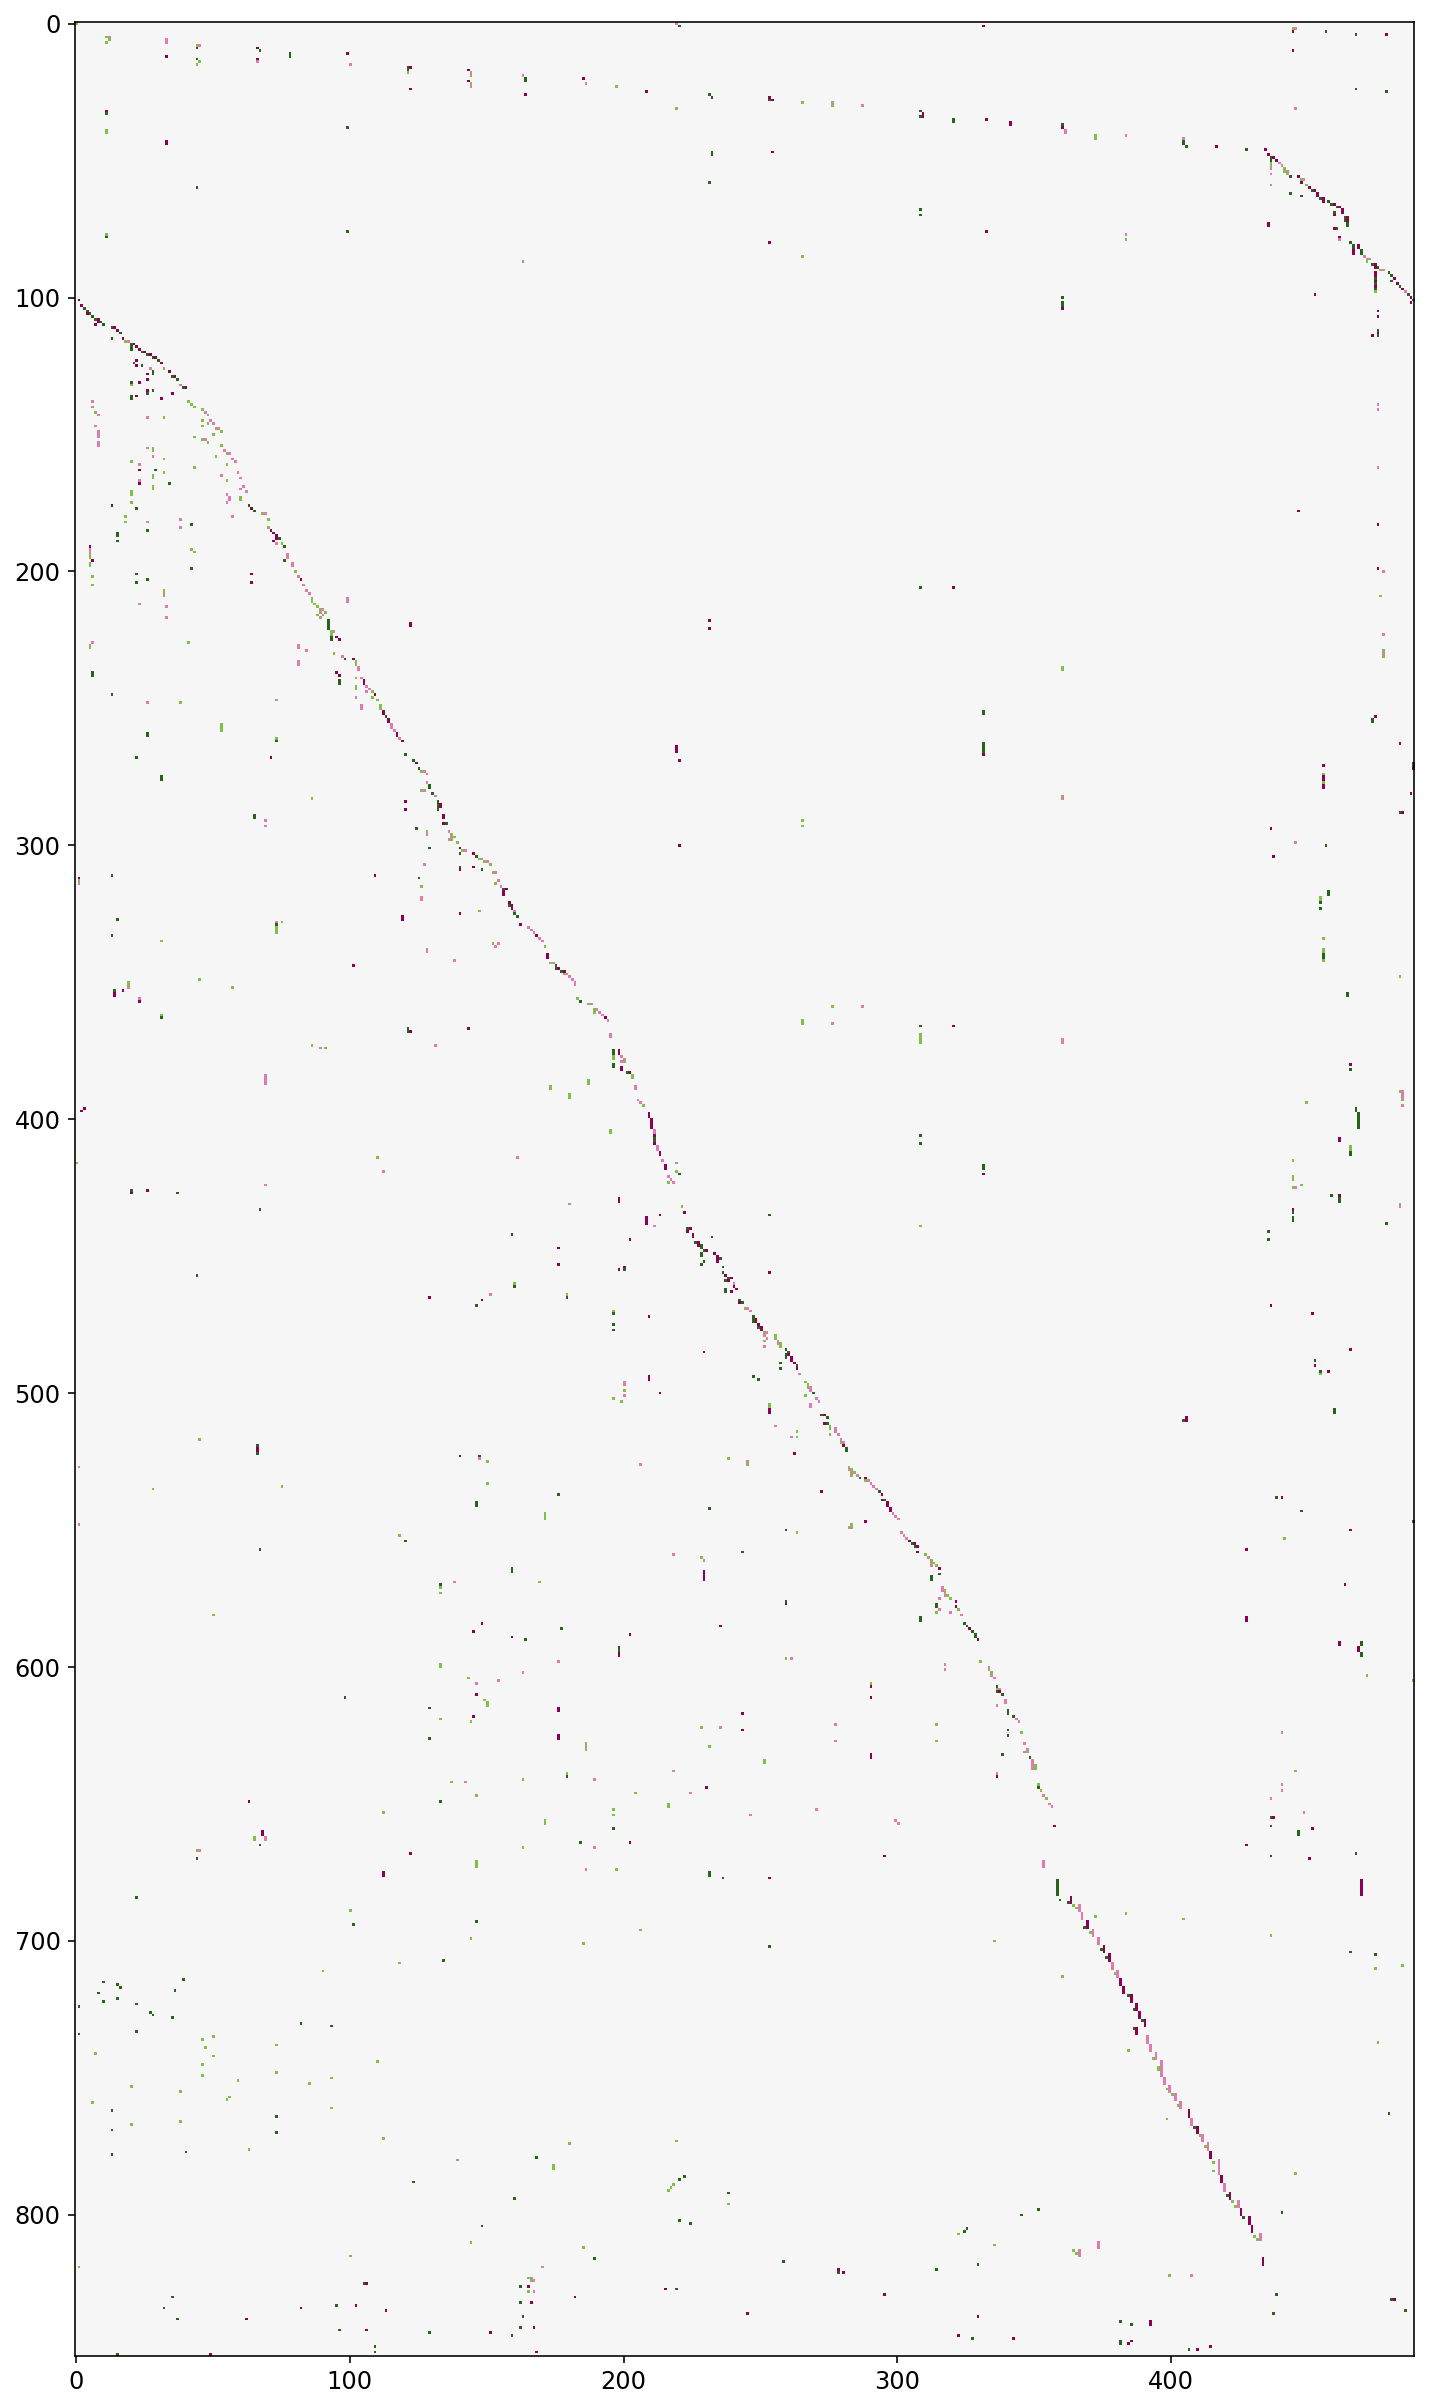

In [9]:
plt.figure(figsize=(12,24))
plt.imshow(CV.todense(), cmap="PiYG")

Note that line reactance and resistance (`x`,`r`) are zero. PyPSA has a built-in method to compute these values as accurately as possible. The algorithm uses the given line type (column `type`) and the number of wires to compute these values. It uses empirical data for each line type.
Looking at the relevant [source code of PyPSA](https://github.com/PyPSA/PyPSA/blob/04cc02c173f1567d512da7fd62ac3d89a6e6e754/pypsa/pf.py#L414), we find that `pypsa.pf.apply_line_types` computes these values.

Note: The columns `g`,`b` are **not** conductance and susceptance, they are *shunt conductivity* and *shunt susceptance*. (See the [PyPSA documentation page](https://pypsa.org/doc/components.html#line).)

In [8]:
pypsa.pf.apply_line_types(network)

We now find that `x` and `r` are defined, as desired. We can use these columns to calculate B, the susceptance, using:

$$\phym{B} = \Im(\phym{Y}) = -\frac{\phym{X}}{\phym{X}^2 + \phym{R}^2}$$

We approximate $\phym{G} = \Re(\phym{Y}) = 0$, so:

$$i\phym{Y} = \Re(i\phym{Y}) + i\Im(i\phym{Y}) = -\Im(\phym{Y}) + i\Re(\phym{Y}) = -\phym{B} = \frac{\phym{X}}{\phym{X}^2 + \phym{R}^2}.$$

We will normalize the voltage at each line. This is no approximation, it is simply a change of units.

Instead of Volts (V), we will use Power Units (pu). 1 pu equals the operating voltage of the line. For example, on a 220kV line, we have 1 pu = 220,000 V. 

This means that the size of pu is not universally defined (as there are multiple operating voltages in most transmission networks). To resolve this, we will define the pu for each line $l$ as pu$_l$. 

For the line admittance of a line $l$, we will use the unit A/pu$_l$ instead of A/V = Ω$^{-1}$

In [9]:
X = network.lines.x.values
R = network.lines.r.values

minusB = X / (X*X + R*R)

i_times_lineadmittance = minusB# * operating_voltage_lines

Similarly to the line admittance of a line $l$, we will change the unit of the line capacity.

Instead of MVA, we will use pu$_l$A.

In [10]:
# TODO: contingency factor
line_capacity = network.lines.s_nom.values# * 1e6 / operating_voltage_lines
if contingency_factor_scaled:
    line_capacity = network.lines.s_nom.values / .7

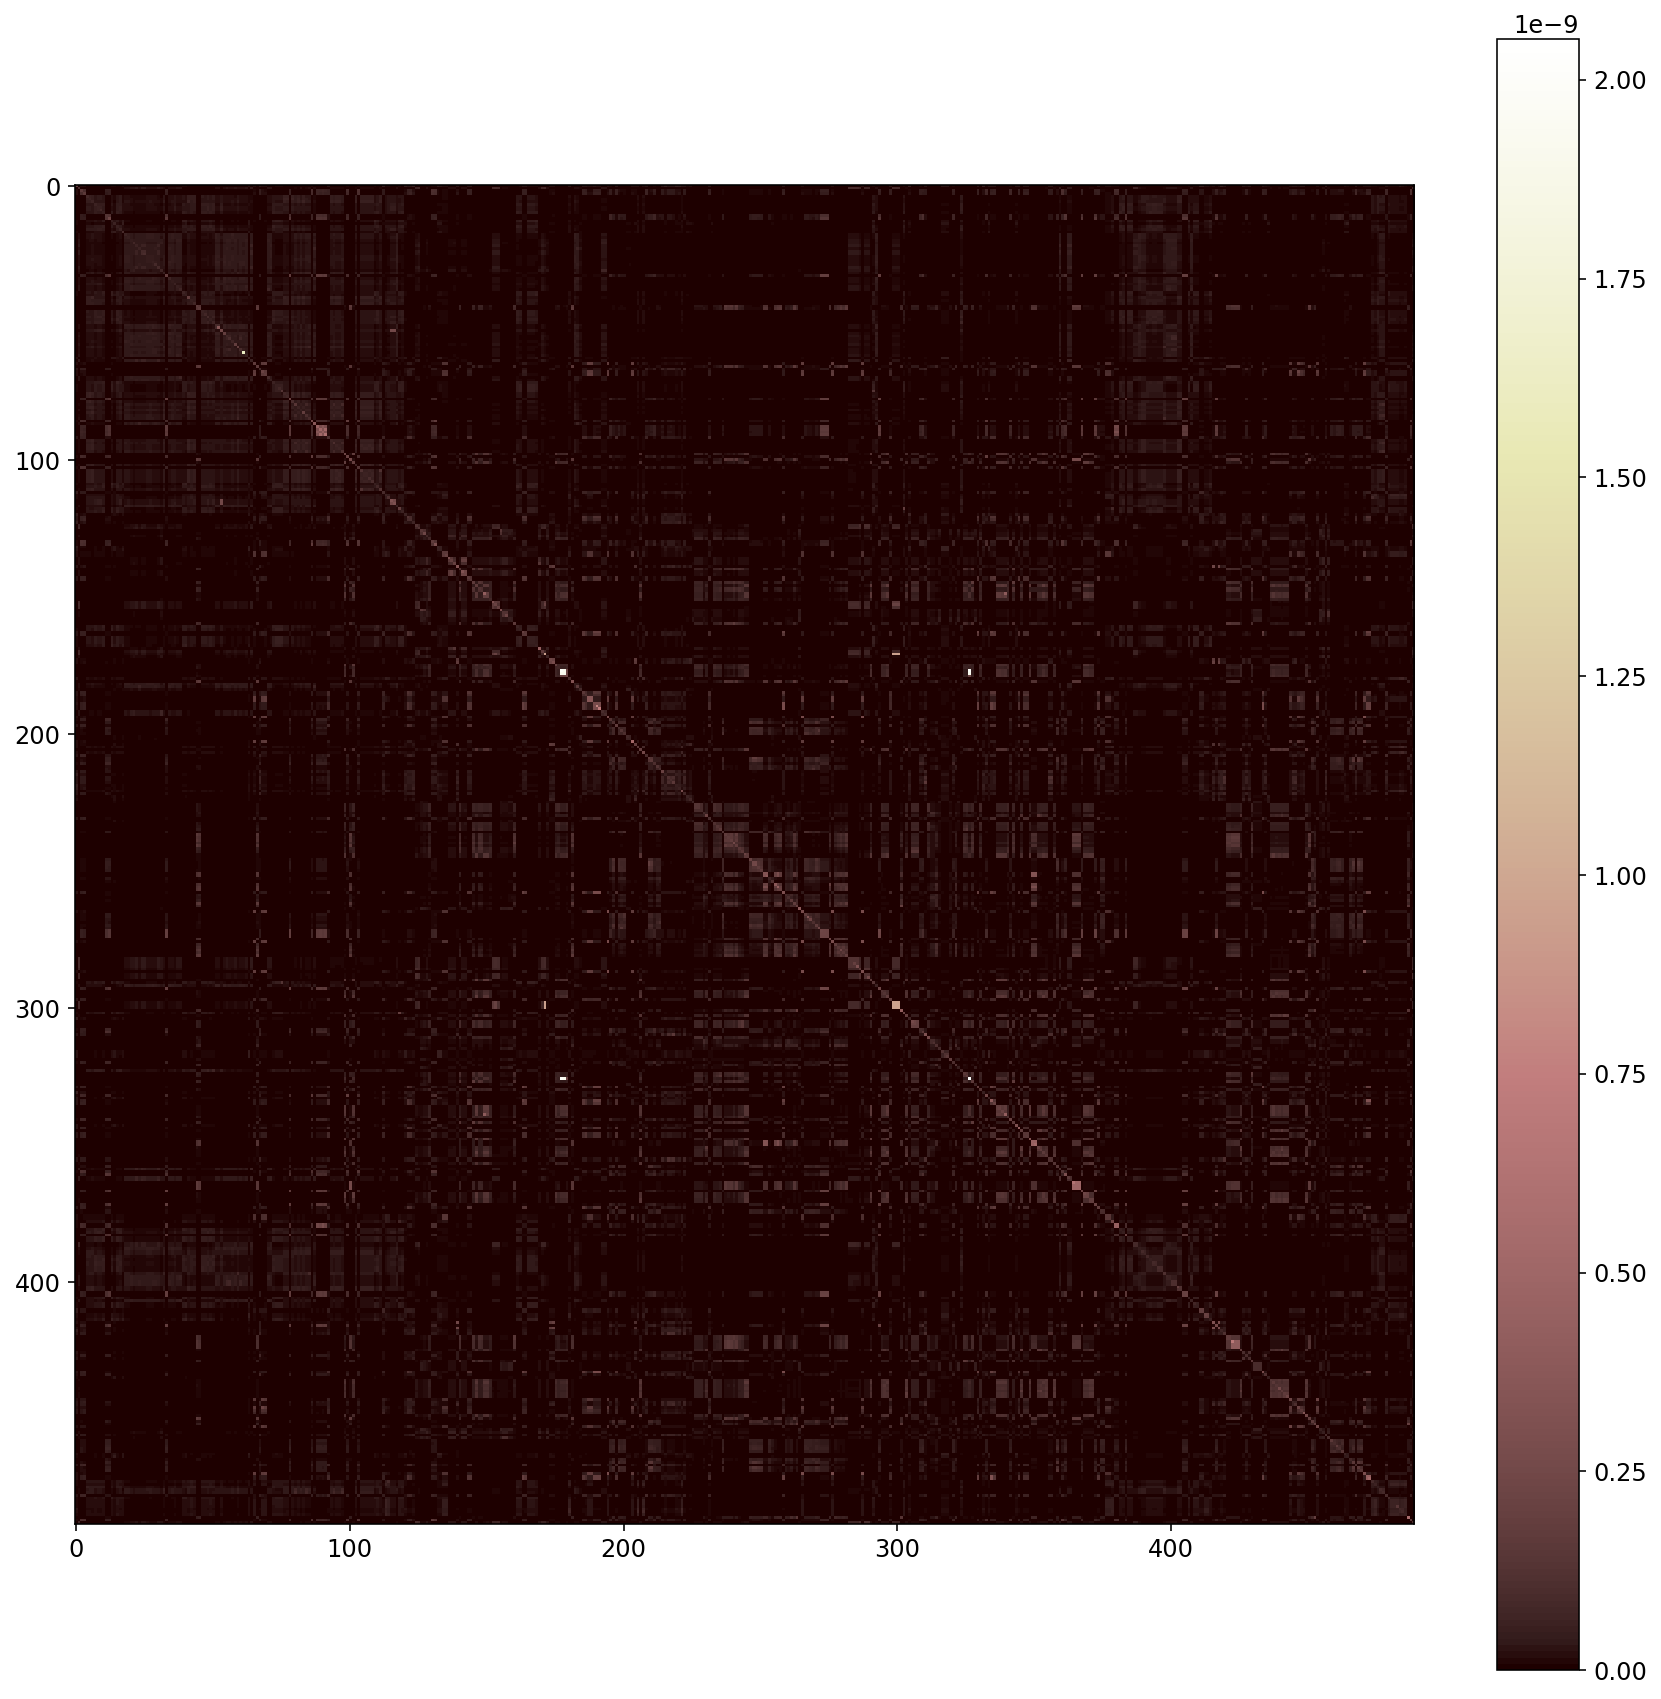

In [11]:
L = CV.T.dot(sp.sparse.diags(i_times_lineadmittance)).dot(CV)

Linv = np.array(np.linalg.pinv(L.todense()))

plt.figure(figsize=(15,15))
plt.imshow(Linv, cmap="pink")
plt.clim(0,np.max(Linv))
plt.colorbar()
plt.show()

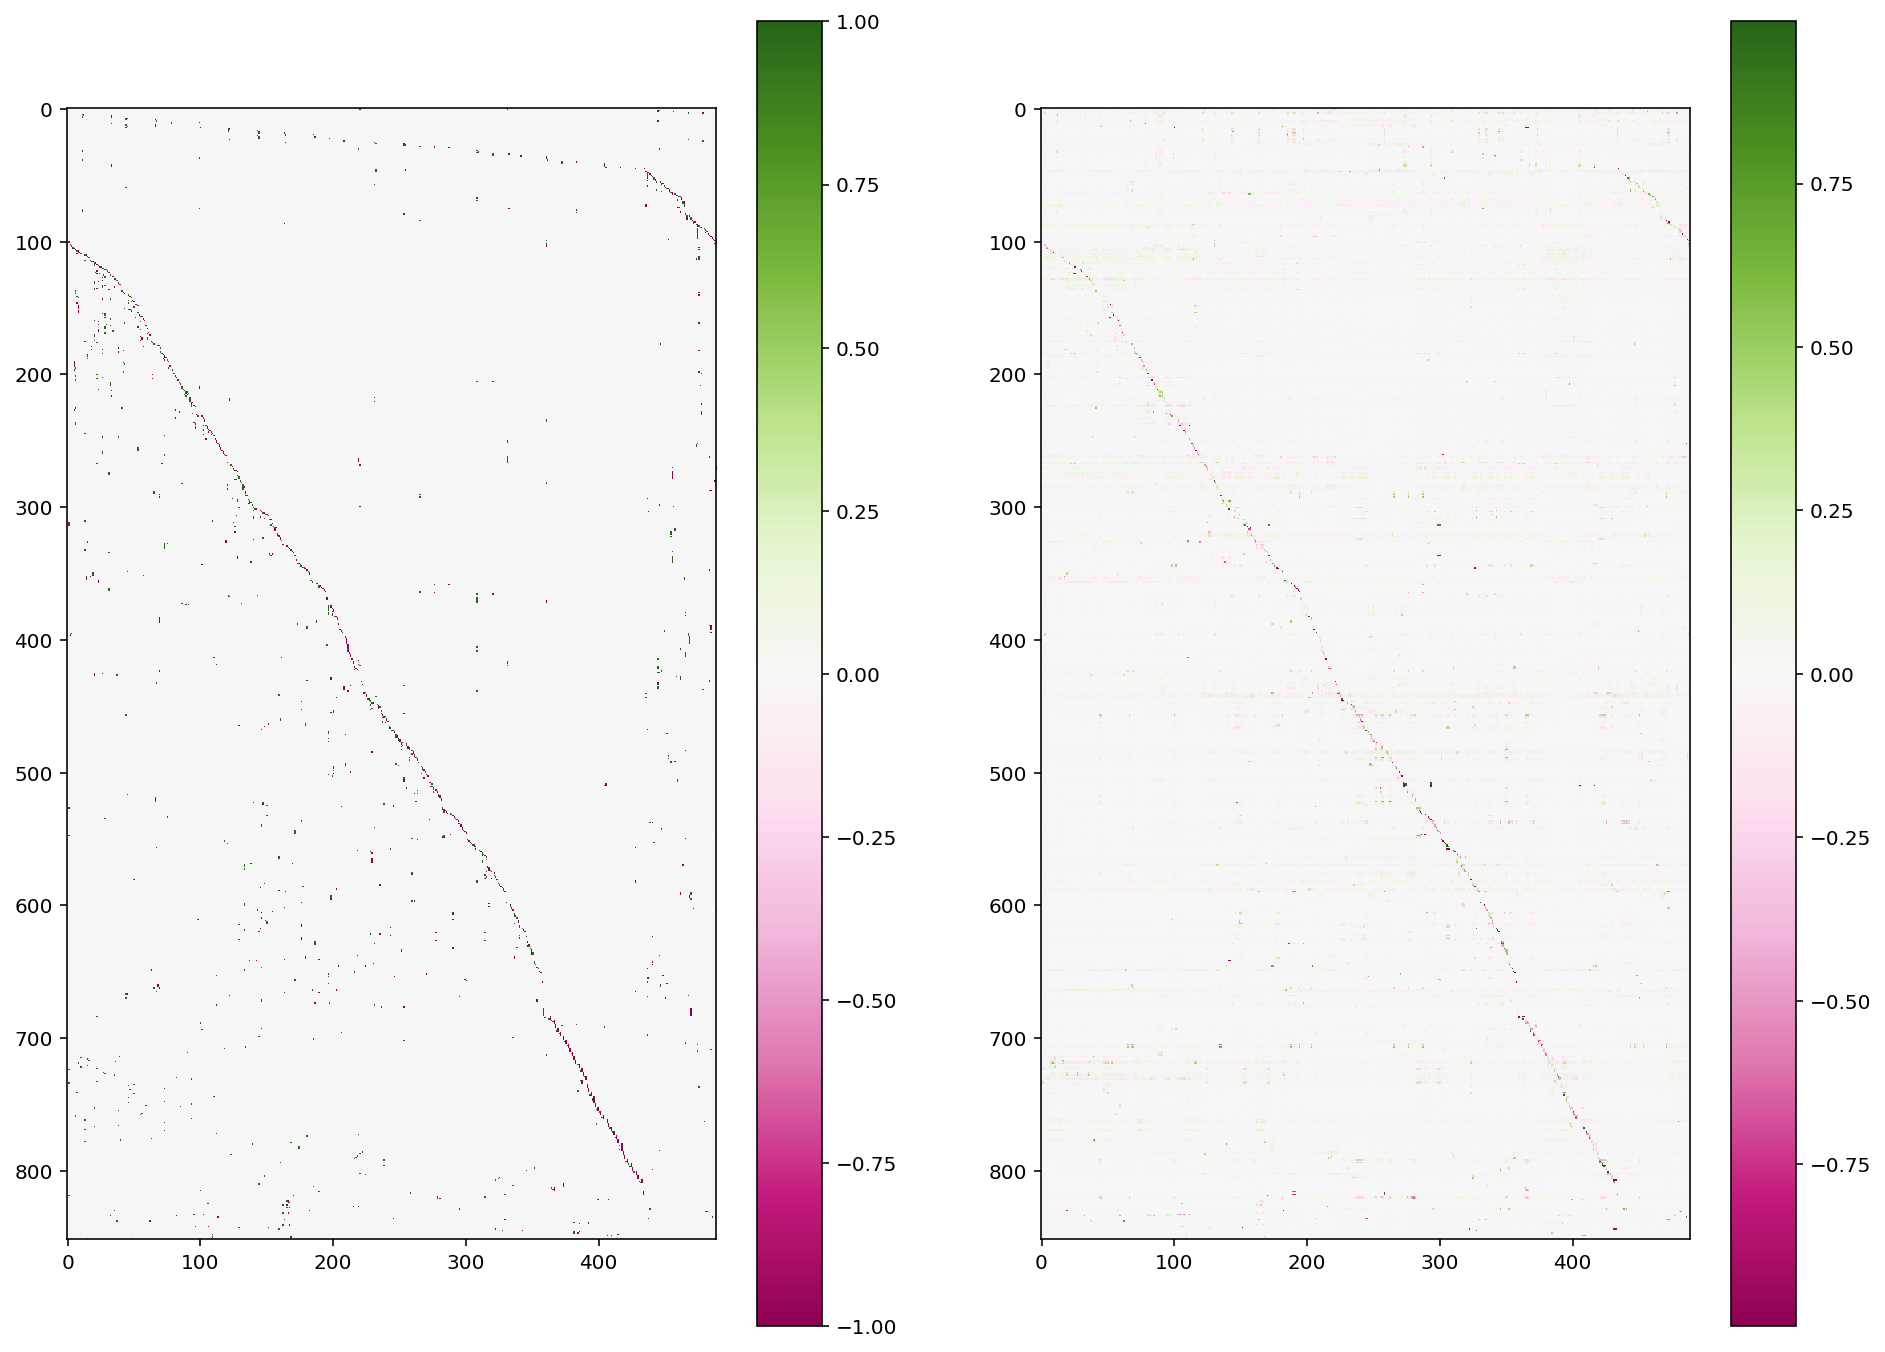

In [13]:
%matplotlib inline

#F = np.multiply(((1/line_capacity)*i_times_lineadmittance)[:,np.newaxis], C.dot(Linv))
F = np.multiply((operating_voltage_lines * i_times_lineadmittance)[:,np.newaxis], CV.dot(Linv))
#F = np.multiply((operating_voltage_lines * operating_voltage_lines * i_times_lineadmittance)[:,np.newaxis], C.dot(Linv))
"""

for bus in network.buses.index:
    voltages = 0
    voltages += len(network.lines.voltage[network.lines.bus0 == bus].values)
    voltages += len(network.lines.voltage[network.lines.bus1 == bus].values)
    print(voltages == 0)
"""


fig = plt.figure(figsize=(16,12))

plt.subplot(1,2,1)
plt.imshow(C.todense(), cmap="PiYG")
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(F, cmap="PiYG")
plt.colorbar()
plt.show()

# Power injection vector
Our dataset includes:
* Hourly load series for almost every node
* Hourly generations series for all renewable generators

Unfortunately, our dataset does not contain:
* Hourly generations series for _all_ generators

The power injection vector, $\mat{p}$, is defined as: $\mel{p}_i$ is the sum of all generators connected to $i$, minus the sum of all loads connected to $i$.

One way to determine the generations series for all other generators is to assume that they are all operating at the same percentage of their maximum capacity. 
* By design, if all other generators are running at 100% of their maximum capacity, the total load is exceeded. (Even if there is 0 renewable generation at that time).
* Renewable energy will be _curtailed_ if the generation exceeds the total load. This means that if all grey generators are running at 0%, the total generation is at most the total load.

This means that there exists some generator configuration at which the total load is met exactly. 

A more realistic estimate would result from running an OPF simulation, which will find a generation series that minimizes costs. This is realistic, since grid operators are using these same simulations to determine their operations. Assuming that we are using a cost function similar to theirs, we expect a result close to reality. (Note that renewable energy has generation costs close to zero. A grid operator (who want to maximise profits) will therefore always try to utilize renewable sources as much as possible, as long as there is no threat to grid security.)

## OPF
We will use the PyPSA package to run an OPF simulation, following the steps from [the PyPSA SciGRID example](https://www.pypsa.org/examples/scigrid-lopf-then-pf.html).

In [49]:
if not contingency_factor_scaled:
    contingency_factor = 0.7
    network.lines.s_nom = contingency_factor*network.lines.s_nom
    contingency_factor_scaled = True

In [50]:
for line_name in ["316","527","602"]:
    network.lines.loc[line_name,"s_nom"] = 1200

In [51]:
group_size = 4

solver_name = "glpk"

print("Performing linear OPF for one day, {} snapshots at a time:".format(group_size))

network.storage_units.state_of_charge_initial = 0.

for i in range(int(24/group_size)):
    #set the initial state of charge based on previous round
    if i>0:
        network.storage_units.state_of_charge_initial = network.storage_units_t.state_of_charge.loc[network.snapshots[group_size*i-1]]
    network.lopf(network.snapshots[group_size*i:group_size*i+group_size],
                 solver_name=solver_name,
                 keep_files=False)
    network.lines.s_nom = network.lines.s_nom_opt

Performing linear OPF for one day, 4 snapshots at a time:


INFO:pypsa.pf:Slack bus for sub-network 0 is 1
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using glpk


Solver log file: 'C:\dev\grid-analysis\notebooks\explorative\tmpdojtb4pm.glpk.log'
Solver solution file: 'C:\dev\grid-analysis\notebooks\explorative\tmpbg3s39va.glpk.raw'
Solver problem files: ('C:\\dev\\grid-analysis\\notebooks\\explorative\\tmpfam5o1jo.pyomo.lp',)


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 1449687.2501478
  Upper bound: 1449687.2501478
  Number of objectives: 1
  Number of constraints: 14025
  Number of variables: 12281
  Number of nonzeros: 33267
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 5.881284475326538
# ----------------------------------------------------------
#   Solution Information
# -------

INFO:pypsa.pf:Slack bus for sub-network 0 is 1
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using glpk


Solver log file: 'C:\dev\grid-analysis\notebooks\explorative\tmpoc_7ylaq.glpk.log'
Solver solution file: 'C:\dev\grid-analysis\notebooks\explorative\tmpxljdd4xd.glpk.raw'
Solver problem files: ('C:\\dev\\grid-analysis\\notebooks\\explorative\\tmp4b_kf4sa.pyomo.lp',)


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 873763.90232936
  Upper bound: 873763.90232936
  Number of objectives: 1
  Number of constraints: 14025
  Number of variables: 12281
  Number of nonzeros: 33267
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 5.735380411148071
# ----------------------------------------------------------
#   Solution Information
# -------

INFO:pypsa.pf:Slack bus for sub-network 0 is 1
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using glpk


Solver log file: 'C:\dev\grid-analysis\notebooks\explorative\tmpr8b5hsp8.glpk.log'
Solver solution file: 'C:\dev\grid-analysis\notebooks\explorative\tmpysflqf2e.glpk.raw'
Solver problem files: ('C:\\dev\\grid-analysis\\notebooks\\explorative\\tmpizr6drkq.pyomo.lp',)


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 790786.594882226
  Upper bound: 790786.594882226
  Number of objectives: 1
  Number of constraints: 14025
  Number of variables: 12281
  Number of nonzeros: 33267
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 7.705136299133301
# ----------------------------------------------------------
#   Solution Information
# -----

INFO:pypsa.pf:Slack bus for sub-network 0 is 1
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using glpk


Solver log file: 'C:\dev\grid-analysis\notebooks\explorative\tmp7dyg0glg.glpk.log'
Solver solution file: 'C:\dev\grid-analysis\notebooks\explorative\tmp3aw44ett.glpk.raw'
Solver problem files: ('C:\\dev\\grid-analysis\\notebooks\\explorative\\tmp33yfx_ik.pyomo.lp',)


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 1455232.6782739
  Upper bound: 1455232.6782739
  Number of objectives: 1
  Number of constraints: 14025
  Number of variables: 12281
  Number of nonzeros: 33267
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 7.439640998840332
# ----------------------------------------------------------
#   Solution Information
# -------

INFO:pypsa.pf:Slack bus for sub-network 0 is 1
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using glpk


Solver log file: 'C:\dev\grid-analysis\notebooks\explorative\tmpngf0hgcs.glpk.log'
Solver solution file: 'C:\dev\grid-analysis\notebooks\explorative\tmp7e0i1m58.glpk.raw'
Solver problem files: ('C:\\dev\\grid-analysis\\notebooks\\explorative\\tmpn6qgq27d.pyomo.lp',)


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 2647879.91201594
  Upper bound: 2647879.91201594
  Number of objectives: 1
  Number of constraints: 14025
  Number of variables: 12281
  Number of nonzeros: 33267
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 5.471566915512085
# ----------------------------------------------------------
#   Solution Information
# -----

INFO:pypsa.pf:Slack bus for sub-network 0 is 1
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using glpk


Solver log file: 'C:\dev\grid-analysis\notebooks\explorative\tmpden8x5tv.glpk.log'
Solver solution file: 'C:\dev\grid-analysis\notebooks\explorative\tmprovyghbu.glpk.raw'
Solver problem files: ('C:\\dev\\grid-analysis\\notebooks\\explorative\\tmpu4xqju0o.pyomo.lp',)


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 2139360.37637067
  Upper bound: 2139360.37637067
  Number of objectives: 1
  Number of constraints: 14025
  Number of variables: 12281
  Number of nonzeros: 33267
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 5.322277784347534
# ----------------------------------------------------------
#   Solution Information
# -----

## Using the OPF results

In [52]:
elevenAM = network.generators_t.p.index[11]


power_injection = np.zeros(n)

for generator_name, generation in network.generators_t.p.loc[elevenAM,:].iteritems():
    generator_bus = network.generators.bus[generator_name]
    power_injection[node_index(generator_bus)] += generation# / network.buses.voltage[generator_bus]

for bus_name, load in network.loads_t.p_set.loc[elevenAM,:].iteritems():
    power_injection[node_index(bus_name)] -= load

pd.Series(power_injection).describe()

print(f"Total load: {network.loads_t.p_set.loc[elevenAM,:].sum()} MW")
print(f"Total generation: {network.generators_t.p.loc[elevenAM,:].sum()} MW")
print(f"Generation overshoot: {power_injection.sum()} MW")

Total load: 52524.64000000082 MW
Total generation: 52589.76674893871 MW
Generation overshoot: 65.12674893788744 MW


In [53]:
flow = F.dot(power_injection)

In [54]:
pd.Series(np.abs(flow)).describe()

count     852.000000
mean      202.796236
std       258.054849
min         0.050741
25%        39.870143
50%       102.761703
75%       264.023396
max      2043.249344
dtype: float64

## Comparing models
How does our linearised power flow ($\mat{F}$) compare to the PyPSA model? We can create a scatter plot of line flows to compare the two models. If the models are very similar, then the points should lie close to the $y=x$ line.
Let's plot the points

$$(\text{flow of $l$ computed by PyPSA}, \quad\text{flow of $l$ computed using $\mat{F}$})$$

for each line $l$.

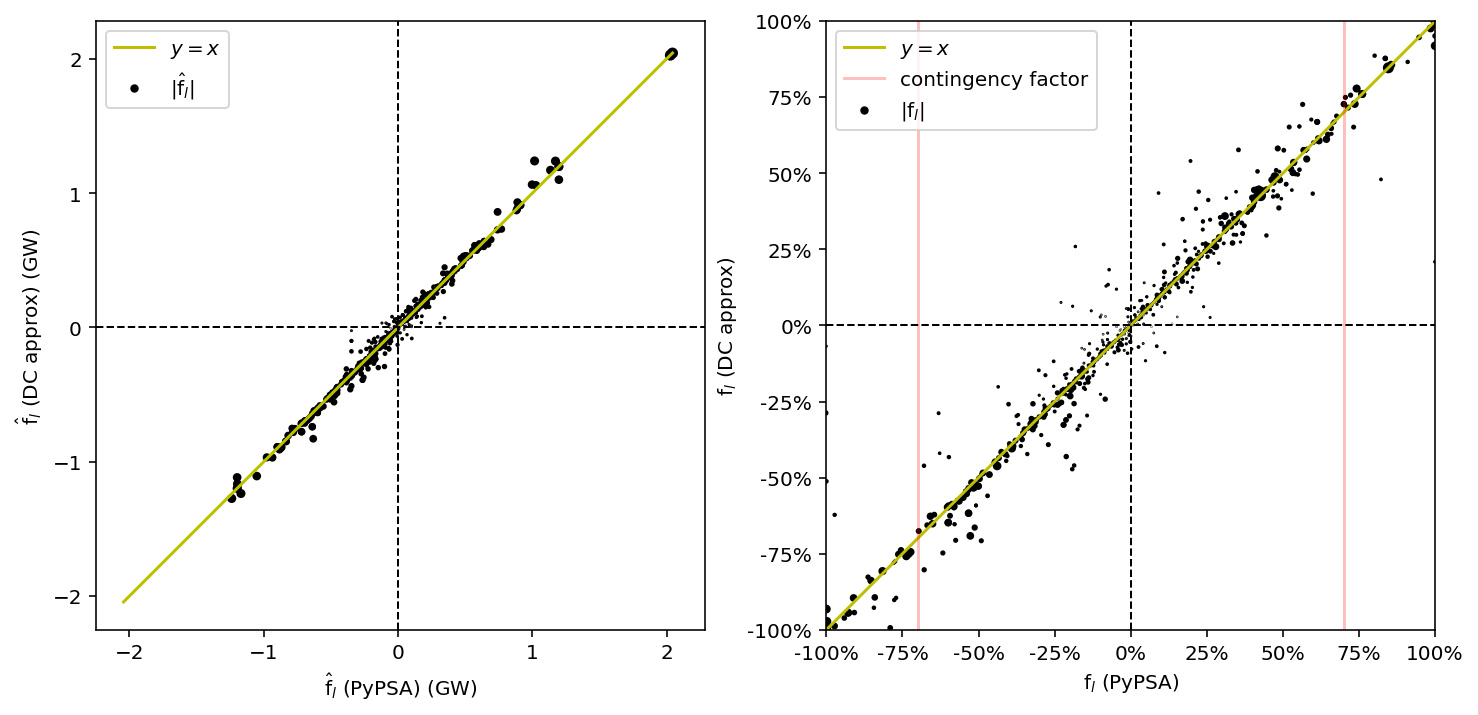

In [55]:
fig = plt.figure(figsize=(12,6))

model = network.lines_t.p0.loc[elevenAM,:].values

ax1 = plt.subplot(1,2,1)

max_flow = max(np.max(np.abs(model)),np.max(np.abs(flow)))
x= np.array([-max_flow, max_flow])
plt.plot(x/1e3,x/1e3,c='y',label='$y=x$')
plt.scatter(model/1e3, flow/1e3,c='black',s=np.abs(flow)*1e-2, label='$|\hat{\mathrm{f}}_l|$')
plt.xlabel("$\hat{\mathrm{f}}_l$ (PyPSA) (GW)")
plt.ylabel("$\hat{\mathrm{f}}_l$ (DC approx) (GW)")
#plt.grid(linestyle='--')

plt.axhline(0,c='0',linewidth=1,linestyle='--')
plt.axvline(0,c='0',linewidth=1,linestyle='--')
ax1.set_aspect('equal')

plt.legend()


ax2 = plt.subplot(1,2,2)

max_flow = max(np.max(np.abs(model/line_capacity)),np.max(np.abs(flow/line_capacity)))
x= np.array([-max_flow, max_flow])
plt.plot(x,x,c='y',label='$y=x$')
plt.scatter(model/line_capacity, flow/line_capacity,c='black',s=np.abs(flow)*1e-2, label='$|{\mathrm{f}}_l|$')
plt.xlabel("${\mathrm{f}}_l$ (PyPSA)")
plt.ylabel("${\mathrm{f}}_l$ (DC approx)")

plt.axvline(-contingency_factor, color='r', alpha=.25)
plt.axvline(contingency_factor, color='r', alpha=.25, label='contingency factor')

ax2.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda z, _: '{:.0%}'.format(z)))
ax2.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda z, _: '{:.0%}'.format(z)))
#plt.grid(linestyle='--')

plt.xlim(-1,1)
plt.ylim(-1,1)

plt.axhline(0,c='0',linewidth=1,linestyle='--')
plt.axvline(0,c='0',linewidth=1,linestyle='--')
ax2.set_aspect('equal')

plt.legend()

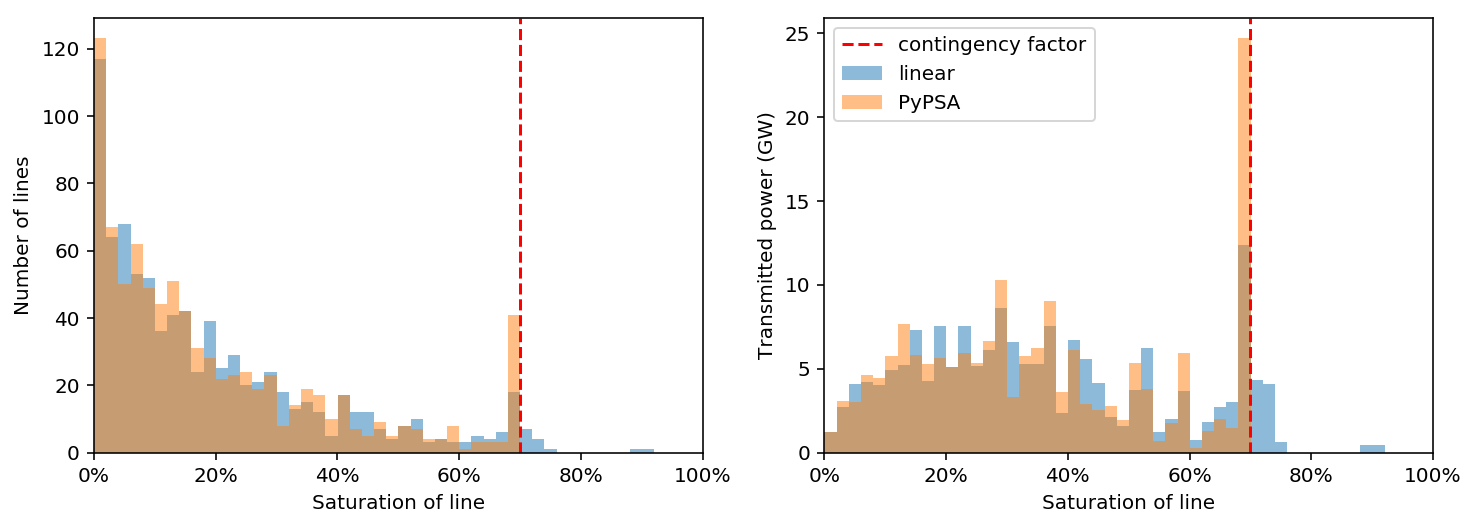

In [56]:
fig = plt.figure(figsize=(12,4))
ax1 = plt.subplot(1,2,1)

bins = (np.arange(50)+.01)*.02
plt.hist(contingency_factor*np.abs(flow/line_capacity), bins=bins, label="linear", alpha=.5)
plt.hist(contingency_factor*np.abs(model/line_capacity), bins=bins, label="PyPSA", alpha=.5)
plt.axvline(contingency_factor, label="contingency factor", color='r', linestyle='--')
plt.xlim(0,1)
ax1.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda z, _: '{:.0%}'.format(z)))
plt.ylabel("Number of lines")
plt.xlabel("Saturation of line")
#plt.legend()


ax2 = plt.subplot(1,2,2)

bins = (np.arange(50)+.01)*.02
plt.hist(contingency_factor*np.abs(flow/line_capacity), bins=bins, weights=np.abs(flow)/1e3, label="linear", alpha=.5)
plt.hist(contingency_factor*np.abs(model/line_capacity), bins=bins, weights=np.abs(model)/1e3, label="PyPSA", alpha=.5)
plt.axvline(contingency_factor, label="contingency factor", color='r', linestyle='--')
plt.xlim(0,1)
ax2.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda z, _: '{:.0%}'.format(z)))
plt.ylabel("Transmitted power (GW)")
plt.xlabel("Saturation of line")
plt.legend()


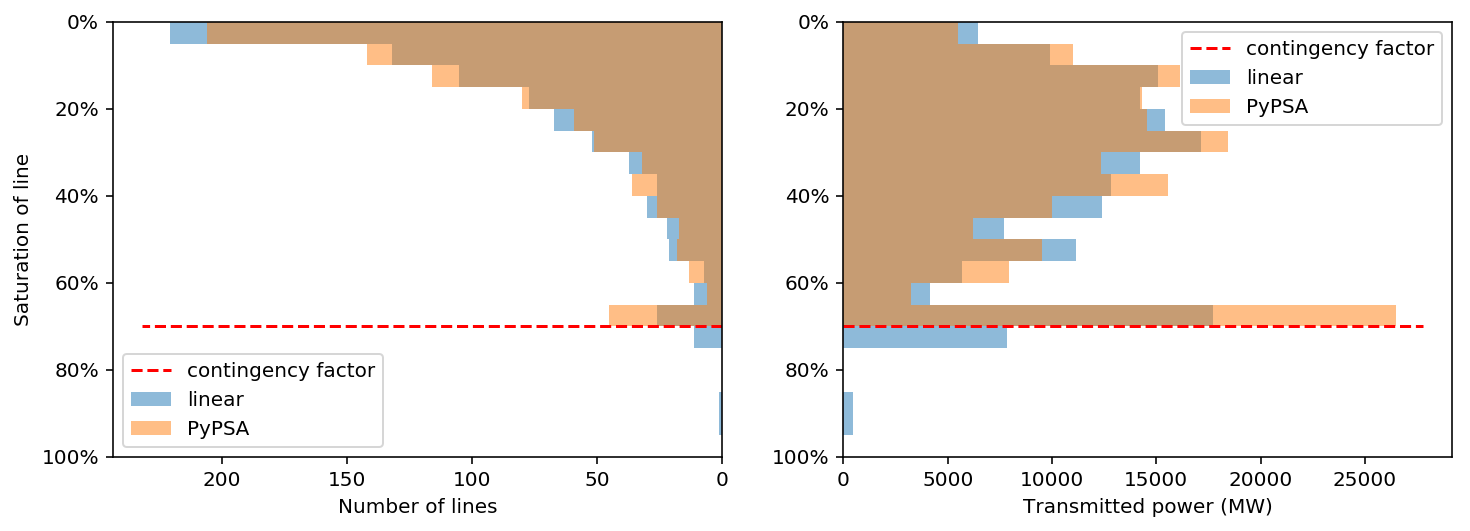

In [57]:
fig = plt.figure(figsize=(12,4))

ax1 = plt.subplot(1,2,1)

bins = (np.arange(20)+.01)*.05
plt.hist(contingency_factor*np.abs(flow/line_capacity), bins=bins, label="linear", alpha=.5, orientation='horizontal')
plt.hist(contingency_factor*np.abs(model/line_capacity), bins=bins, label="PyPSA", alpha=.5, orientation='horizontal')

plt.plot(list(plt.xlim()), [contingency_factor]*2, label="contingency factor", color='r', linestyle='--')

#plt.xlim(0,1)
plt.xlabel("Number of lines")
plt.ylabel("Saturation of line")

old_xlim_left, old_xlim_right = plt.xlim()
plt.xlim(old_xlim_right, old_xlim_left)

ax1.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda z, _: '{:.0%}'.format(z)))

plt.legend()


ax2 = plt.subplot(1,2,2, sharey=ax1)

bins = (np.arange(20)+.01)*.05
plt.hist(contingency_factor*np.abs(flow/line_capacity), bins=bins, weights=np.abs(flow), label="linear", alpha=.5, orientation='horizontal')
plt.hist(contingency_factor*np.abs(model/line_capacity), bins=bins, weights=np.abs(model), label="PyPSA", alpha=.5, orientation='horizontal')

plt.plot(list(plt.xlim()), [contingency_factor]*2, label="contingency factor", color='r', linestyle='--')

plt.xlabel("Transmitted power (MW)")
#plt.ylabel("Saturation of line")
plt.ylim(1,0)
plt.legend()
#ax2.label_outer()
ax2.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, _: '{:.0%}'.format(x))) 

#fig.subplots_adjust(wspace=0)

We see that in the PyPSA model, many lines are operatoring almost exactly at 70% capacity. This is quite unrealistic, since the contingency factor (70%) was chosen somewhat arbitrarily. It is most likely a side effect of the OPF process (solved using linear programming), where an artificial solution is produced that is very close to the edge of allowed states.

NameError: name 'power_injection' is not defined

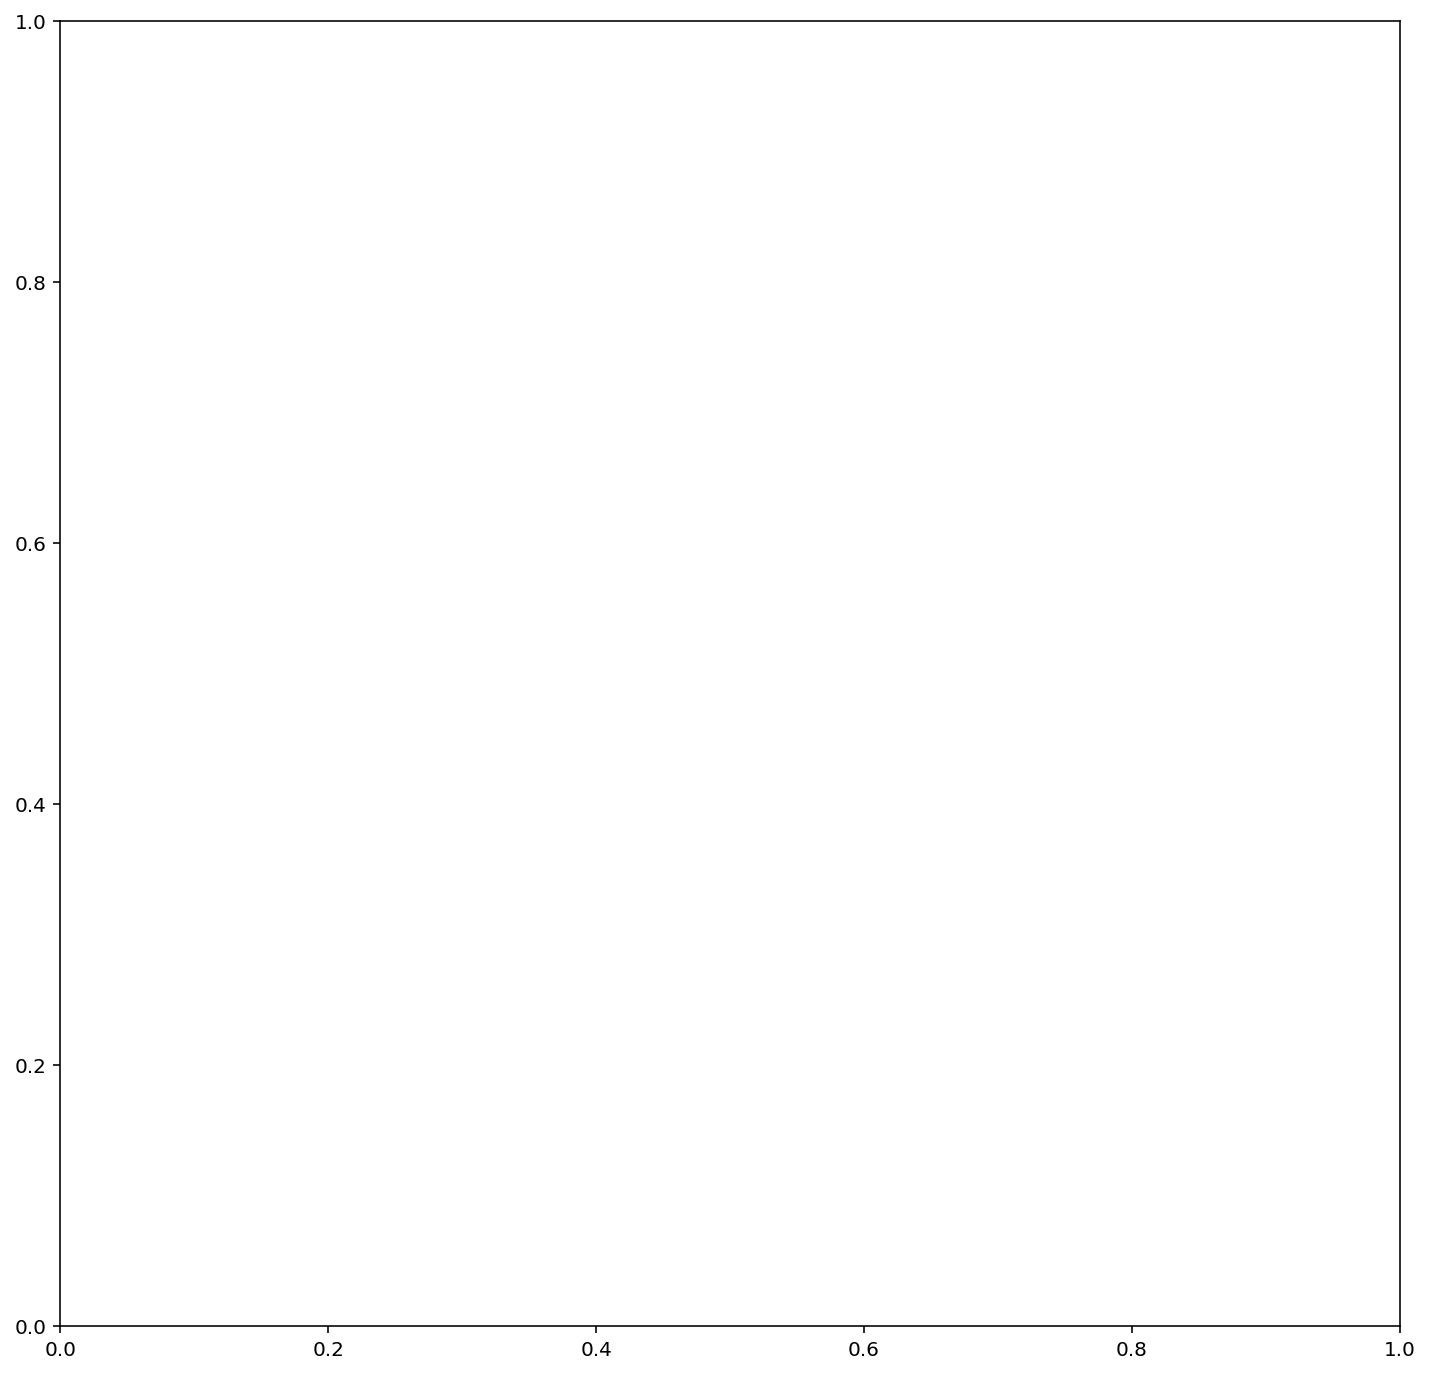

In [38]:
%matplotlib inline

fig, ax = plt.subplots()
fig.set_size_inches(12,12)


bus_sizes = [0]*len(network.buses)
bus_colors = ['g']*len(network.buses)

for i, bus_name in enumerate(network.buses.index):
    if bus_name in generator_buses:
        powerinj = power_injection[node_index(bus_name)]
        bus_sizes[i] = np.abs(powerinj) * .2
        bus_colors[i] = 'y' if powerinj < 0 else 'g'


#line_widths = C.dot(power_injection)
line_widths = np.abs(flow/(line_capacity/.7))
line_widths = np.clip(line_widths, 0, 1)
#line_widths = np.abs(flow - model)

pretty = True
if pretty:
    d = {'projection': 'tmerc', 'lon_0':10.0,'lat_0':50.0,'resolution':'h', }
else:
    d = {'resolution':'c', }
pathcol, linecol = network.plot(bus_colors=bus_colors,
             bus_sizes=bus_sizes,
             line_widths=2,
             line_colors=line_widths,
             line_cmap=matplotlib.cm.get_cmap("magma_r"),
             ax=ax,
             basemap=d,
             wet_color='#f0f0fa',
             meridian_sep=2.,parallel_sep=2.0)

cb = fig.colorbar(linecol, ax=ax)

#plt.savefig('nominallineflow.pdf',format='pdf',bbox_inches='tight')

<IPython.core.display.Javascript object>


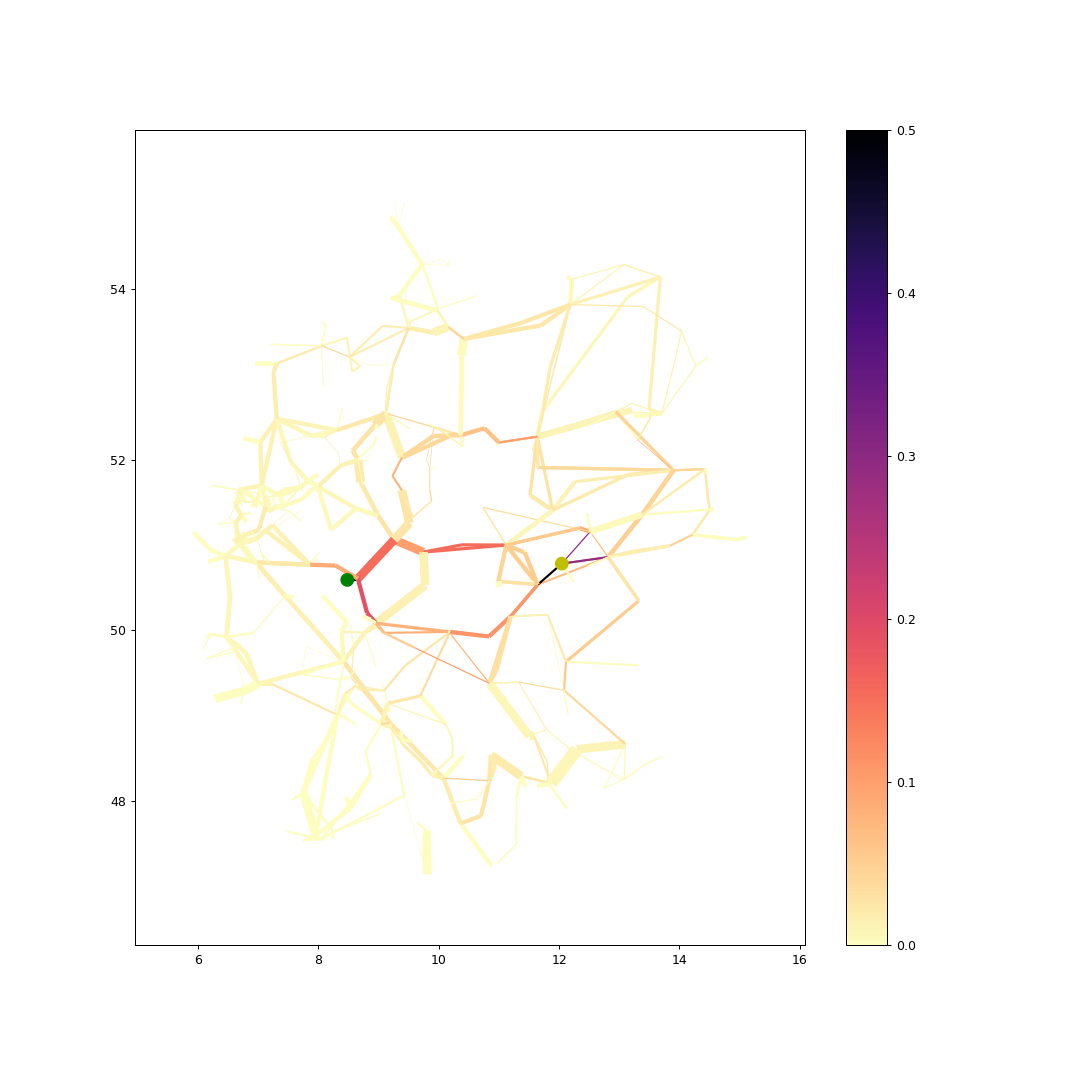

In [18]:
%matplotlib notebook

fig = plt.figure(figsize=(12,12))
ax = fig.subplots()

prev_choice = 0

def trace_flow(from_idx, to_idx):
    global linecol
    p = np.zeros(n)

    p[from_idx]=1000
    p[to_idx]=-1000

    f = F.dot(p)

    bus_sizes = [0]*len(network.buses)
    bus_colors = ['g']*len(network.buses)

    for i, bus_name in enumerate(network.buses.index):
        if bus_name in generator_buses:
            powerinj = p[node_index(bus_name)]
            bus_sizes[i] = np.abs(powerinj) /10
            bus_colors[i] = 'g' if powerinj > 0 else 'y'




    #line_widths = C.dot(power_injection)
    line_widths = np.abs(f / line_capacity)
    #line_widths = np.clip(line_widths, 0, 1)
    #line_widths = np.abs(flow - model)

    pretty = True
    if pretty:
        d = {'projection': 'tmerc', 'lon_0':10.0,'lat_0':50.0,'resolution':'c', }
    else:
        d = {'resolution':'c', }
    pathcol, linecol = network.plot(bus_colors=bus_colors,
                 bus_sizes=bus_sizes,
                 line_widths=line_capacity/500,
                 line_colors=line_widths,
                 line_cmap=matplotlib.cm.get_cmap("magma_r"),
                 ax=ax,
                 basemap=False,
                 wet_color='#f0f0fa',
                 meridian_sep=2.,parallel_sep=2.0)

    linecol.set_clim(0,.5)
    #plt.savefig('lineflow'+str(node2)+'.png',format='png',bbox_inches='tight')
    #text=ax.text(10,50, str(network.buses.v_nom.loc[new_nodes].index[to_idx])+" at "+str(network.buses.v_nom.loc[new_nodes].values[to_idx]), va="bottom", ha="left")


trace_flow(0,1)
cb = fig.colorbar(linecol, ax=ax)
cb.set_clim(0,.5)

def onclick(event):
    global prev_choice
    tx='x={0}, y={1}'.format(event.xdata, event.ydata)

    s = lambda z: z*z
    dist = lambda a, coord: (s(network.buses.x[a] - coord[0])+s(network.buses.y[a] - coord[1]))

    selected_bus = min(new_nodes, key=lambda a: dist(a, (event.xdata, event.ydata)))
    new_choice = node_index(selected_bus)
    #text.set_text()
    plt.cla()
    trace_flow(prev_choice, new_choice)
    prev_choice = new_choice

cid = fig.canvas.mpl_connect('button_press_event', onclick)
plt.show()


In [60]:
new_nodes[100]

'19'

'100_220kV'